## 1. Juntar datos etiquetados con no etiquetados. Eliminar la etiqueta. 

Vamos a volver a unir los datos no etiquetados con el resto. (tengan a mano la columna de eitiquetas por si necesitan colorear algun grafico o hacer testigos)


## 2. Entrenar modelos de ANS

Estamos buscando algun patron que nos determine si el paciente esta en estado pre-ictal o inter-ictal. Pero ademas estamos buscando otros patrones que podrían ayudarnos a determinar esto. 

Cuando prueben los distintos metodos, asegurense de hacerlo sobre los datos no etiquetados y tambien los etiquetados. Comparen los valores de las etiquetas con respecto a los clusters encontrados. Prueben con distintos numeros de clusters y vean si algun grupo coincide con el grupo de etiquetados en 1 que es el que mas nos intereso recuperar en el practico de supervisado.

### 2.0 - Filtro de outliers v2.0

Prueben el [detector de anomalias](https://scikit-learn.org/stable/modules/outlier_detection.html) de sklearn sobre nuestros datos. Comparenlo con las detecciones realizadas en la etapa de analisis

### 2.1 - Clustering
Exploren los [metodos de clusters](https://scikit-learn.org/stable/modules/clustering.html) que ofrece sklearn y elijan minimo 2 para aplicar a nuestro dataset. Justifiquen la eleccion. Se pueden hacer conclusiones sobre los resultados?

### 2.2 - Manifolds
Nuestro dataset no tiene una dimensionalidad muy alta, sin embargo los embeddings nos pueden proporcionar informacion visual valiosa, similar a la visualizacion de los componentes principales (PCA). Prueben al menos uno de los [manifolds](https://scikit-learn.org/stable/modules/manifold.html) que ofrece sklearn para visualizar nuestros datos en 2 o 3 dimensiones.

## 3. Volvamos a AA

Los analisis hechos en esta etapa sirven para enriquecer nuestro conocimiento sobre nuestros datos. Con esta informacion nueva, quizas podremos incrementar algunos puntos mas las predicciones del practico anterior.

Pueden usar los clusters encontrados en el punto dos como una columna nueva y usarla para entrenar los modelos. Pueden usar el filtro de outliers de sklearn si consideran que mejora la deteccion. 

Mejoran los resultados? Se pueden sacar conclusiones?

## 4. Cuantificadores vs estimadores clasicos (Opcional)

Las columnas de media, varianza y skew, son realmente necesarias? o solo suman ruido? observen como se comportan los modelos cuando quitan esas columnas. Se puede sacar alguna conclusion sobre esto? 

-------------------------------------


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager
import seaborn as sns
import itertools
from scipy import linalg
from sklearn import mixture
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import (
    recall_score, 
    accuracy_score, 
    precision_score, 
    f1_score, 
    roc_auc_score,  
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay,
)
import warnings
warnings.filterwarnings("ignore") 
#sns.set_style("darkgrid")

## Ejercicio 1
Unimos los datos etiquetados a los no etiquetados y les removemos la etiqueta a todos. 

In [2]:
ne_p1 = pd.read_csv('/home/bata/DiploDatos/Mentoria/data_preprocessed/Data_noEtiquetado_P1.csv')
ne_p2 = pd.read_csv('/home/bata/DiploDatos/Mentoria/data_preprocessed/Data_noEtiquetado_P2.csv')
ne_p3 = pd.read_csv('/home/bata/DiploDatos/Mentoria/data_preprocessed/Data_noEtiquetado_P3.csv')
e_p1 = pd.read_csv('/home/bata/DiploDatos/Mentoria/data_preprocessed/Data_test_P1.csv')
e_p2 = pd.read_csv('/home/bata/DiploDatos/Mentoria/data_preprocessed/Data_test_P2.csv')
e_p3 = pd.read_csv('/home/bata/DiploDatos/Mentoria/data_preprocessed/Data_test_P3.csv')

In [3]:
etiquetados = pd.concat([e_p1,e_p2,e_p3]).reset_index(drop=True)
etiquetados = etiquetados.sample(frac=1)
etiquetados = etiquetados.reset_index(drop=True)

In [4]:
no_etiquetados = pd.concat([ne_p1,ne_p2,ne_p3]).reset_index(drop=True)
no_etiquetados = no_etiquetados.sample(frac=1)
no_etiquetados = no_etiquetados.reset_index(drop=True)

In [5]:
etiquetados = etiquetados.dropna(axis=0)
no_etiquetados = no_etiquetados.dropna(axis=0)

In [6]:
datos =  pd.concat([etiquetados,no_etiquetados]).reset_index(drop=True)
datos = datos.sample(frac=1)
datos = datos.reset_index(drop=True)
datos.head()

,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,2.0,0.0,0.472784,0.279359,0.460523,0.528824,0.225247,0.698282,7.113223e-09,34.133765,-0.158125
1,3.0,NaN,0.547645,0.283651,0.580046,0.407311,0.219601,0.758301,1.279992e-06,37.280358,-0.019565
2,3.0,0.0,0.537322,0.284198,0.564590,0.498156,0.282100,0.750313,1.694953e-05,31.451259,0.002908
3,2.0,0.0,0.489891,0.280610,0.487563,0.419666,0.159365,0.711221,-3.243688e-07,39.513751,-0.075346
4,2.0,NaN,0.530416,0.284634,0.554898,0.548954,0.310421,0.745590,-2.296264e-06,42.426944,-0.188916


In [7]:
etiqueta = datos.iloc[:,0:2]
datos_ne = datos.drop(['Patient','State'], axis=1)
etiqueta.head()

,Patient,State
0,2.0,0.0
1,3.0,NaN
2,3.0,0.0
3,2.0,0.0
4,2.0,NaN


In [8]:
datos_ne.head()

,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,0.472784,0.279359,0.460523,0.528824,0.225247,0.698282,7.113223e-09,34.133765,-0.158125
1,0.547645,0.283651,0.580046,0.407311,0.219601,0.758301,1.279992e-06,37.280358,-0.019565
2,0.537322,0.284198,0.564590,0.498156,0.282100,0.750313,1.694953e-05,31.451259,0.002908
3,0.489891,0.280610,0.487563,0.419666,0.159365,0.711221,-3.243688e-07,39.513751,-0.075346
4,0.530416,0.284634,0.554898,0.548954,0.310421,0.745590,-2.296264e-06,42.426944,-0.188916


-----------------------------------
## Ejercicio  2.0 - Filtro de outliers v2.0
Aplicamos varios detectores de anomalías de la pagina de Sklearn a los datos 



### PCA
Primero aplicamos PCA a los datos nuevamente para poder proyectar los resultados de los filtros de outliers sobre las primeras componentes de PCA, de manera de visualizar de alguna forma como actuan estos filtros sobre el dataset

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#etiquetados_sin_features = etiquetados_scale.iloc[:, [0,2,3,4,5,6,7,8,9,10]]
scaled_data = StandardScaler().fit_transform(datos_ne)

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(pca_data, index=range(12010), columns=labels)

### Elliptic Covariance

In [10]:
cov = EllipticEnvelope(random_state=0).fit(datos_ne)
pred = cov.predict(datos_ne)
outliers_cov = pd.DataFrame(pred, columns=['outlier_cov'])

In [11]:
outliers_cov.head()

,outlier_cov
0,-1
1,1
2,1
3,1
4,1


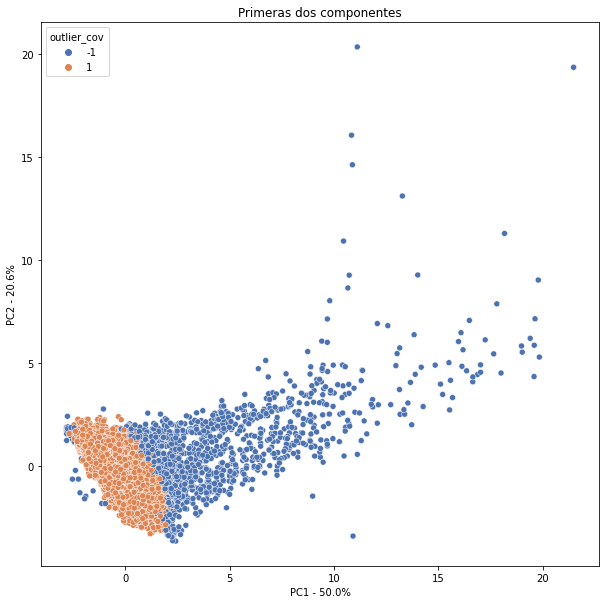

In [12]:
pca_cov = pca_df.join(outliers_cov)

fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_cov, hue='outlier_cov', palette="deep")
plt.title('Primeras dos componentes')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
#plt.savefig('pca_2comp.jpg', bbox_inches = 'tight') 
plt.show()

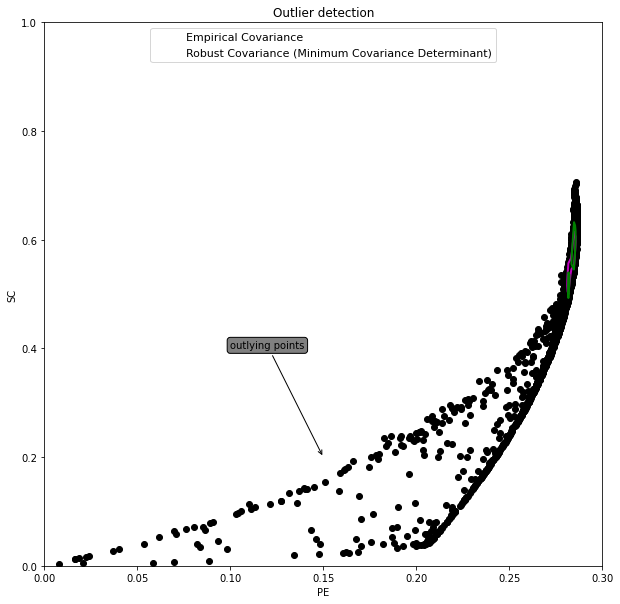

In [13]:
# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(contamination=0.25),
}
colors = ["m", "g"]
legend1 = {}
legend2 = {}

# Get data
X1 = datos_ne.iloc[:, [1, 2]]
#X1 = X1.to_numpy          # two clusters

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 0.3, 100), np.linspace(0, 1, 100))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X1.values)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

X1_np = X1.to_numpy()

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))  # two clusters
plt.title("Outlier detection")
plt.scatter(X1_np[:, 0], X1_np[:, 1], color="black")
bbox_args = dict(boxstyle="round", fc="0.5")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outlying points",
    xy=(0.15, 0.2),
    xycoords="data",
    textcoords="data",
    xytext=(0.10, 0.4),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0]),
    (legend1_keys_list[0], legend1_keys_list[1]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("SC")
plt.xlabel("PE")

plt.show()


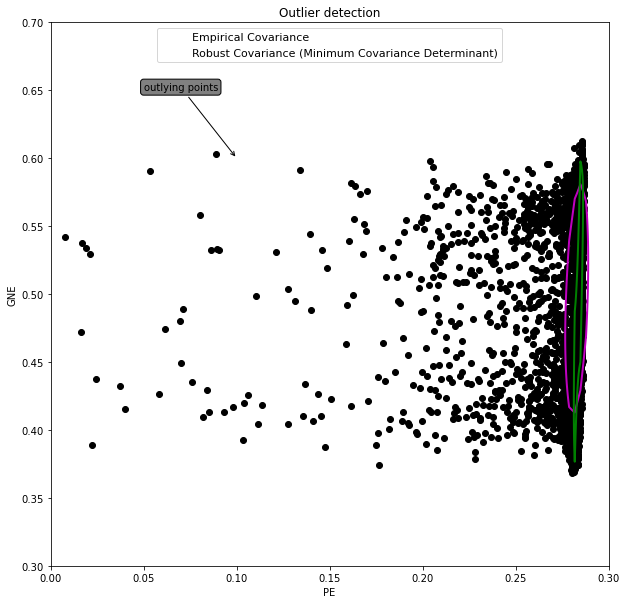

In [14]:
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(contamination=0.25),
}
colors = ["m", "g"]
legend1 = {}
legend2 = {}

# Get data
X1 = datos_ne.iloc[:, [1, 3]]
#X1 = X1.to_numpy          # two clusters

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 0.3, 100), np.linspace(0.3, 0.7, 100))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X1.values)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

X1_np = X1.to_numpy()

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))  # two clusters
plt.title("Outlier detection")
plt.scatter(X1_np[:, 0], X1_np[:, 1], color="black")
bbox_args = dict(boxstyle="round", fc="0.5")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outlying points",
    xy=(0.10, 0.60),
    xycoords="data",
    textcoords="data",
    xytext=(0.05, 0.65),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0]),
    (legend1_keys_list[0], legend1_keys_list[1]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("GNE")
plt.xlabel("PE")

plt.show()


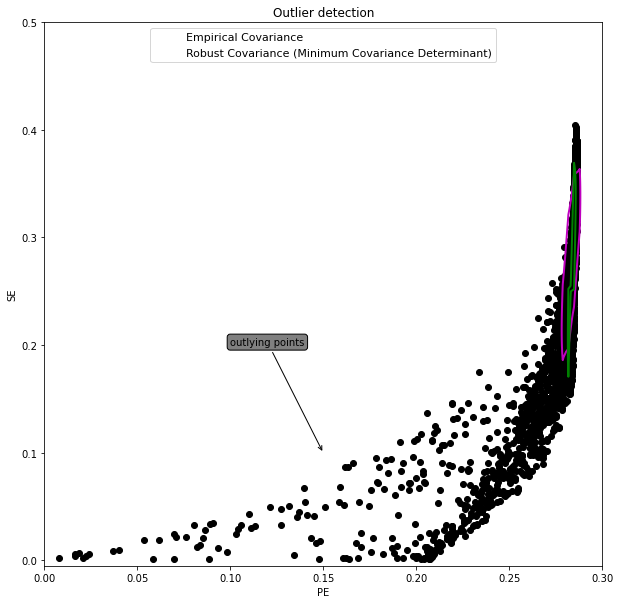

In [15]:
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(contamination=0.25),
}
colors = ["m", "g"]
legend1 = {}
legend2 = {}

# Get data
X1 = datos_ne.iloc[:, [1, 4]]
#X1 = X1.to_numpy          # two clusters

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 0.3, 100), np.linspace(-0.005, 0.5, 100))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X1.values)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

X1_np = X1.to_numpy()

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))  # two clusters
plt.title("Outlier detection")
plt.scatter(X1_np[:, 0], X1_np[:, 1], color="black")
bbox_args = dict(boxstyle="round", fc="0.5")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outlying points",
    xy=(0.15, 0.1),
    xycoords="data",
    textcoords="data",
    xytext=(0.10, 0.2),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0]),
    (legend1_keys_list[0], legend1_keys_list[1]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("SE")
plt.xlabel("PE")

plt.show()


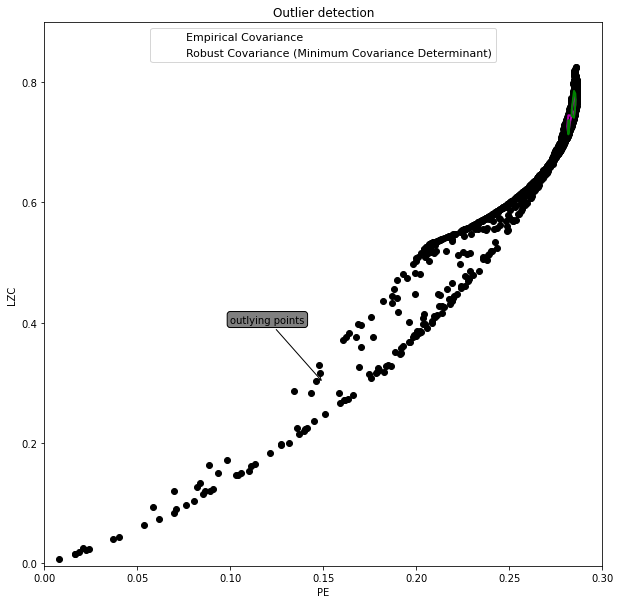

In [16]:
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(contamination=0.25),
}
colors = ["m", "g"]
legend1 = {}
legend2 = {}

# Get data
X1 = datos_ne.iloc[:, [1, 5]]
#X1 = X1.to_numpy          # two clusters

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 0.3, 100), np.linspace(-0.005, 0.9, 100))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X1.values)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

X1_np = X1.to_numpy()

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))  # two clusters
plt.title("Outlier detection")
plt.scatter(X1_np[:, 0], X1_np[:, 1], color="black")
bbox_args = dict(boxstyle="round", fc="0.5")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outlying points",
    xy=(0.15, 0.3),
    xycoords="data",
    textcoords="data",
    xytext=(0.10, 0.4),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0]),
    (legend1_keys_list[0], legend1_keys_list[1]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("LZC")
plt.xlabel("PE")

plt.show()

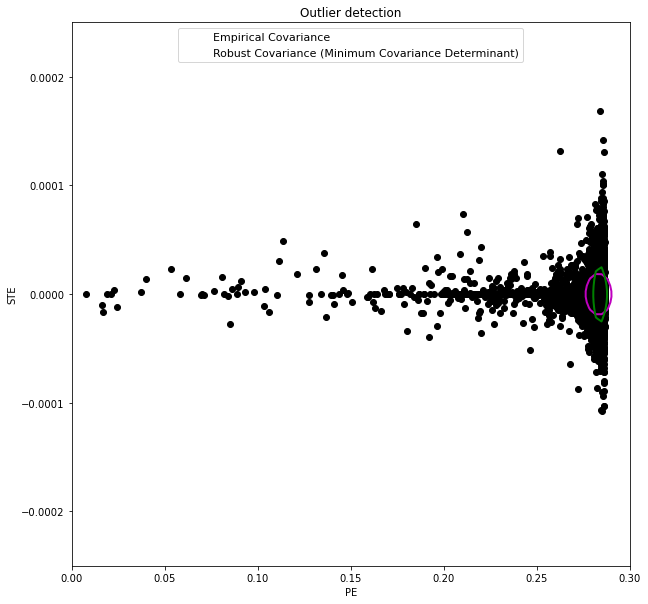

In [17]:
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(contamination=0.25),
}
colors = ["m", "g"]
legend1 = {}
legend2 = {}

# Get data
X1 = datos_ne.iloc[:, [1, 6]]
#X1 = X1.to_numpy          # two clusters

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 0.3, 100), np.linspace(-0.00025, 0.00025, 100))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X1.values)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

X1_np = X1.to_numpy()

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))  # two clusters
plt.title("Outlier detection")
plt.scatter(X1_np[:, 0], X1_np[:, 1], color="black")
bbox_args = dict(boxstyle="round", fc="0.5")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outlying points",
    xy=(0.15, 0.1),
    xycoords="data",
    textcoords="data",
    xytext=(0.10, 0.2),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0]),
    (legend1_keys_list[0], legend1_keys_list[1]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("STE")
plt.xlabel("PE")

plt.show()


### Isolation Forest 
Para implementar este método es necesario separar el dataset en un conjunto de prueba y otro de entrnamiento, ambos sin etiquetas. 

In [18]:
iso = IsolationForest(random_state=0).fit_predict(datos_ne)
outliers_iso = pd.DataFrame(iso, columns=['outlier_iso'])

In [19]:
outliers_iso.head()

,outlier_iso
0,1
1,1
2,1
3,1
4,1


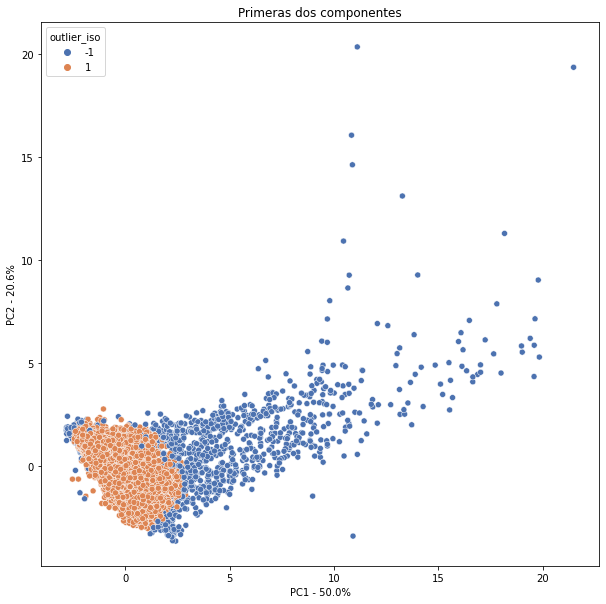

In [20]:
pca_iso = pca_df.join(outliers_iso)

fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_iso, hue='outlier_iso', palette="deep")
plt.title('Primeras dos componentes')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
#plt.savefig('pca_2comp.jpg', bbox_inches = 'tight') 
plt.show()

### Local Outlier Factor

In [21]:
lof = LocalOutlierFactor(n_neighbors=5).fit_predict(datos_ne)
outliers_lof = pd.DataFrame(lof, columns=['outlier_lof'])

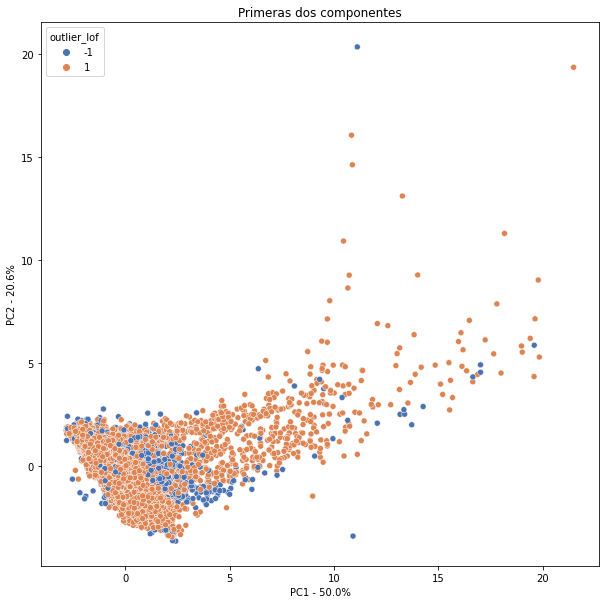

In [22]:
pca_lof = pca_df.join(outliers_lof)

fig = plt.figure(figsize=(10,10))  
colors = {'-1':'blue', '1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_lof, hue='outlier_lof', palette="deep")
plt.title('Primeras dos componentes')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
#plt.savefig('pca_2comp.jpg', bbox_inches = 'tight') 
plt.show()

Seleccionamos dos variables que no esten correlacionadas usando heatmap y graficamos ambas para los filtros de outliers


<AxesSubplot:>

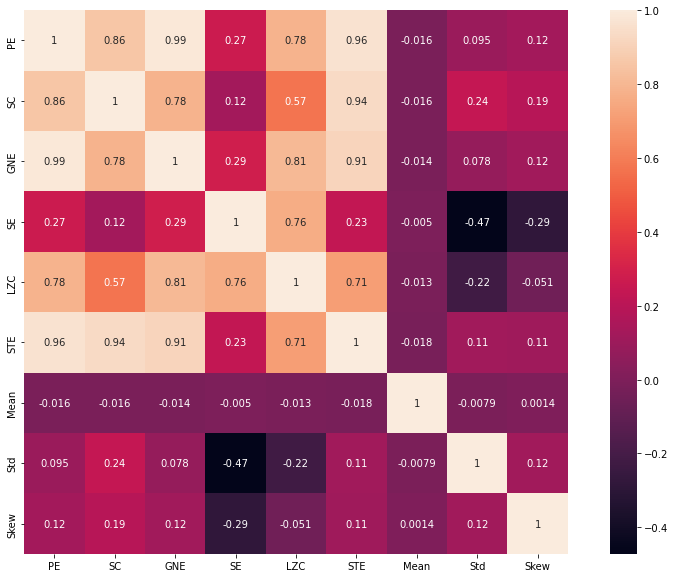

In [23]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(datos_ne.corr(), annot=True, square=True)

In [24]:
outliers = [outliers_cov,outliers_iso,outliers_lof]
datos_outliers = datos_ne.join(outliers)
datos_outliers.head()

,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew,outlier_cov,outlier_iso,outlier_lof
0,0.472784,0.279359,0.460523,0.528824,0.225247,0.698282,7.113223e-09,34.133765,-0.158125,-1,1,1
1,0.547645,0.283651,0.580046,0.407311,0.219601,0.758301,1.279992e-06,37.280358,-0.019565,1,1,1
2,0.537322,0.284198,0.564590,0.498156,0.282100,0.750313,1.694953e-05,31.451259,0.002908,1,1,1
3,0.489891,0.280610,0.487563,0.419666,0.159365,0.711221,-3.243688e-07,39.513751,-0.075346,1,1,1
4,0.530416,0.284634,0.554898,0.548954,0.310421,0.745590,-2.296264e-06,42.426944,-0.188916,1,1,1


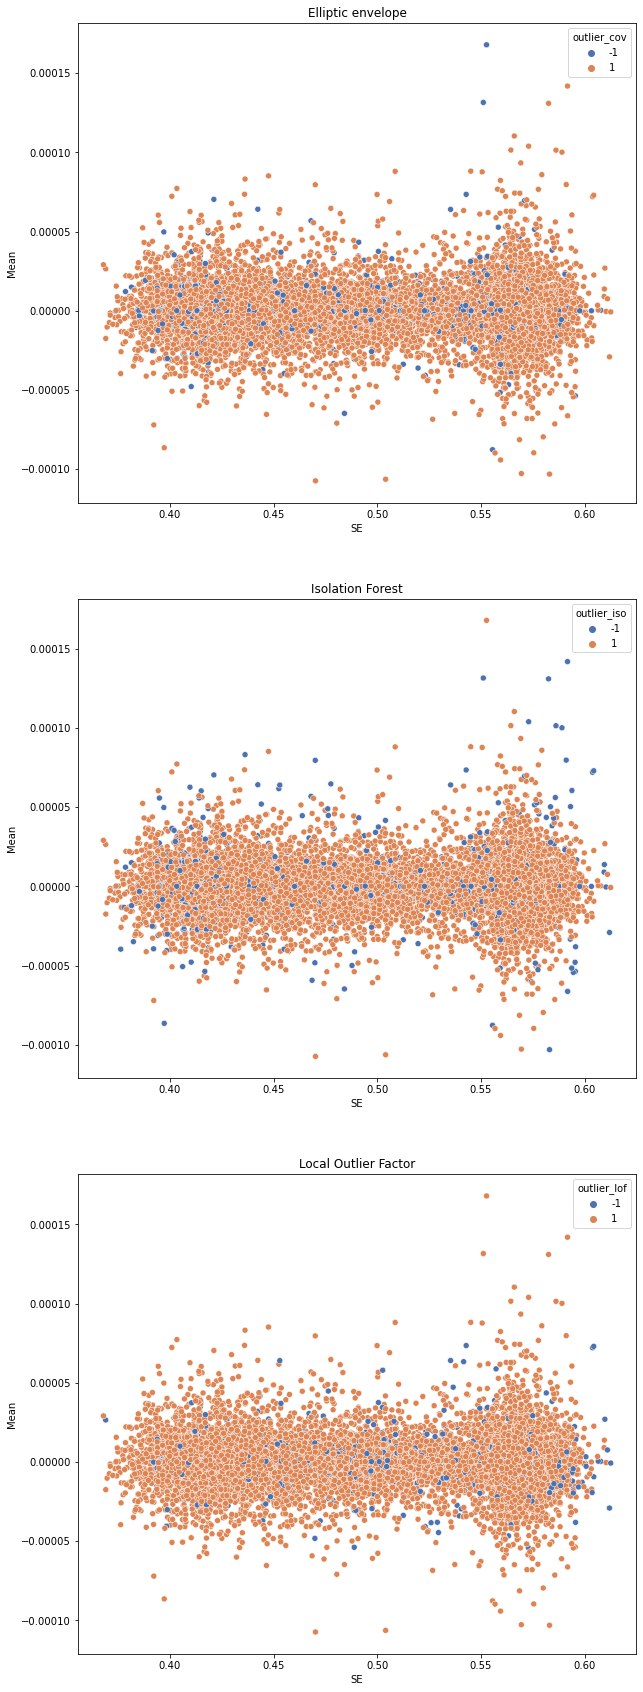

In [25]:
outliers_fil = ['outlier_cov','outlier_iso','outlier_lof']
titles = ['Elliptic envelope', 'Isolation Forest', 'Local Outlier Factor']
plt.subplots(3,1,figsize=(10,30))
for out in outliers_fil:
    plt.subplot(3,1,outliers_fil.index(out)+1) 
    colors = {'-1':'blue', '1':'orange'}
    sns.scatterplot(x='SE', y='Mean', data=datos_outliers, hue=out, palette="deep")
    plt.title(titles[outliers_fil.index(out)])
    plt.xlabel('SE')
    plt.ylabel('Mean')

No se observan separaciones apreciables con nignuno de los filtros de anomalias aplicados sobre las componentes principales ni sobre las variables elegidas que no estan correlacionadas


------------------------
## Ejercicio 2.1 - Clustering 

### Spectral clustering

In [27]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(2, n_init=100, assign_labels='discretize')
datos_sc = sc.fit_predict(datos_ne)  

In [28]:
datos_sc

array([0, 0, 0, ..., 0, 1, 1])

Text(0, 0.5, 'PC2 - 20.6%')

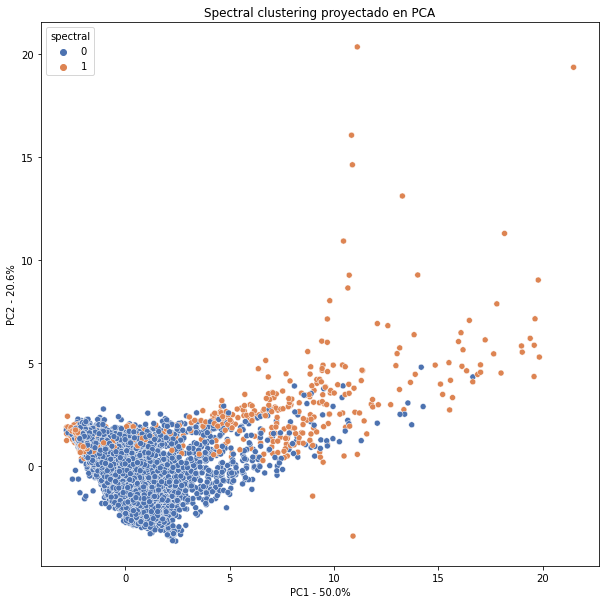

In [29]:
spec_clus = pd.DataFrame(datos_sc, columns=['spectral'])

pca_spectral = pca_df.join(spec_clus)

fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_spectral, hue='spectral', palette="deep")
plt.title('Spectral clustering proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

### DBSCAN 

In [30]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3, min_samples=8)
datos_dbscan = dbscan.fit_predict(datos_ne)

In [31]:
datos_dbscan

array([0, 0, 0, ..., 0, 0, 0])

Text(0, 0.5, 'PC2 - 20.6%')

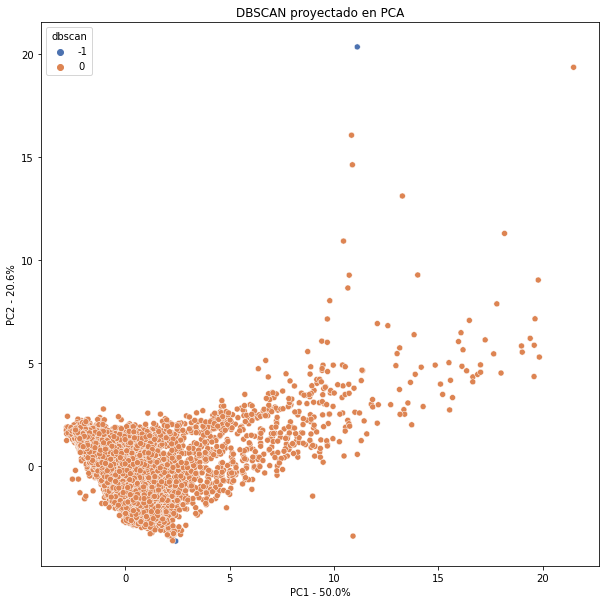

In [32]:
dbscan_pd = pd.DataFrame(datos_dbscan, columns=['dbscan'])

pca_dbscan = pca_df.join(dbscan_pd)

fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_dbscan, hue='dbscan', palette="deep")
plt.title('DBSCAN proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

### BIRCH

In [33]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=2)
datos_birch = brc.fit_predict(datos_ne)

In [34]:
datos_birch

array([1, 0, 0, ..., 0, 1, 1])

Text(0, 0.5, 'PC2 - 20.6%')

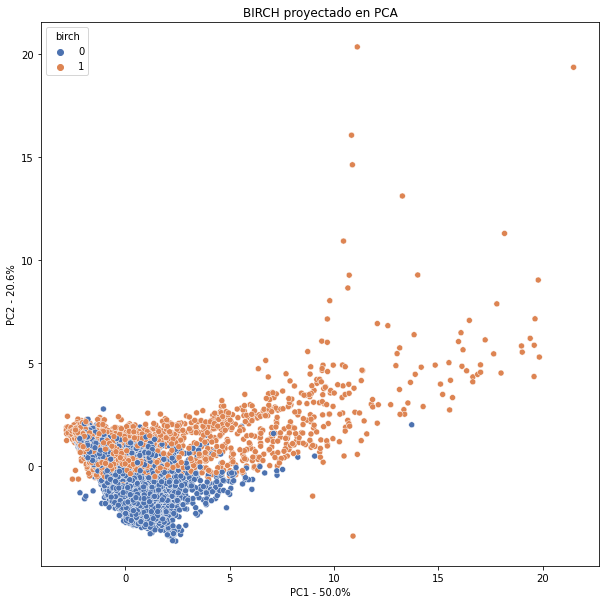

In [35]:
birch_pd = pd.DataFrame(datos_birch, columns=['birch'])

pca_birch = pca_df.join(birch_pd)

fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_birch, hue='birch', palette="deep")
plt.title('BIRCH proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

### Gaussian Mixture (mezcla de Gausianas)

In [36]:
from sklearn.mixture import GaussianMixture

In [37]:
gm = GaussianMixture(n_components=2, random_state=0)
datos_gm = gm.fit_predict(datos_ne)

In [38]:
datos_gm

array([1, 1, 1, ..., 1, 1, 0])

Text(0, 0.5, 'PC2 - 20.6%')

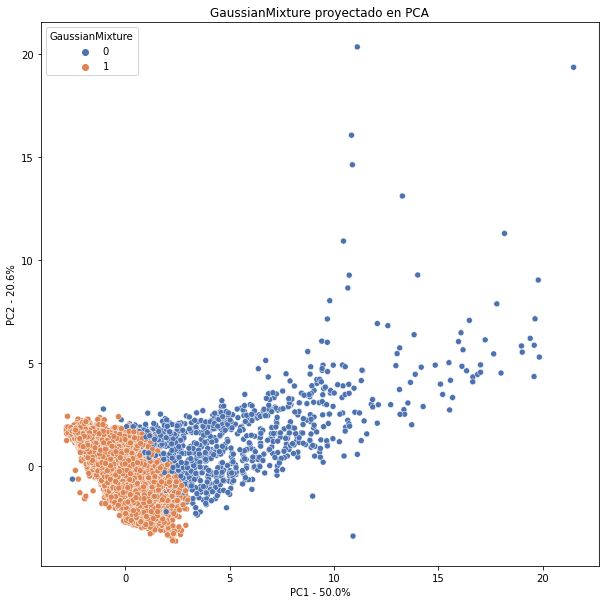

In [39]:
gm_pd = pd.DataFrame(datos_gm, columns=['GaussianMixture'])

pca_gm = pca_df.join(gm_pd)

fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_gm, hue='GaussianMixture', palette="deep")
plt.title('GaussianMixture proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

## Ejercicio 2.2 - Manifolds

### SpectralEmbedding

In [40]:
from sklearn.manifold import SpectralEmbedding

In [41]:
embedding_se = SpectralEmbedding(n_components=2)
datos_se = embedding_se.fit_transform(datos_ne)

In [42]:
datos_se.shape

(12010, 2)

In [43]:
se_pd = pd.DataFrame(datos_se, columns=['SpectralEmbedding_1','SpectralEmbedding_2'])
se_pd = etiquetados.join(se_pd)

Text(0, 0.5, 'SpectralEmbedding_2')

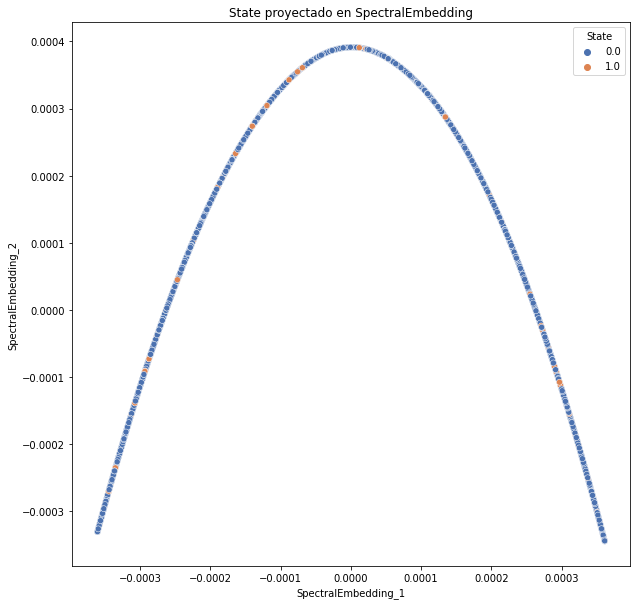

In [44]:
fig = plt.figure(figsize=(10,10))  
sns.scatterplot(x='SpectralEmbedding_1', y='SpectralEmbedding_2', data=se_pd, hue='State', palette="deep")
plt.title('State proyectado en SpectralEmbedding')
plt.xlabel('SpectralEmbedding_1')
plt.ylabel('SpectralEmbedding_2' )

### Isomap

In [45]:
from sklearn.manifold import Isomap

In [46]:
embedding_isomap = Isomap(n_components=2)
datos_isomap = embedding_isomap.fit_transform(datos_ne)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [47]:
datos_isomap.shape

(12010, 2)

In [48]:
isomap_pd = pd.DataFrame(datos_isomap, columns=['isomap_1','isomap_2'])
isomap_pd = etiquetados.join(isomap_pd)

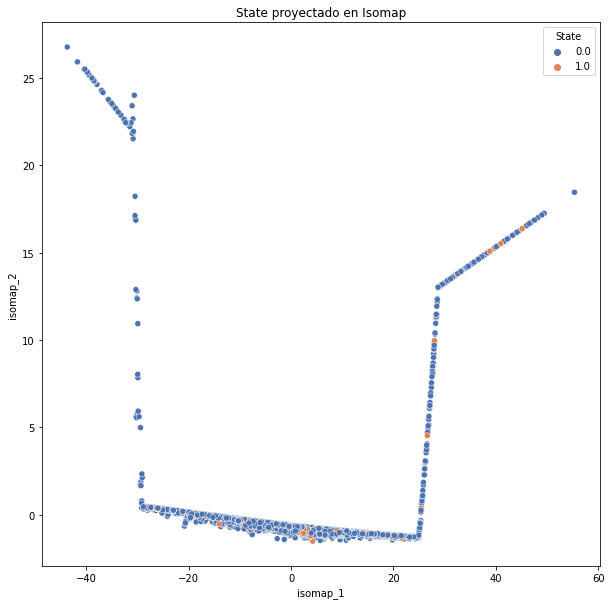

In [49]:
fig = plt.figure(figsize=(10,10))  
sns.scatterplot(x='isomap_1', y='isomap_2', data=isomap_pd, hue='State', palette="deep")
plt.title('State proyectado en Isomap')
plt.xlabel('isomap_1')
plt.ylabel('isomap_2')
plt.show()

## Ejercicio 3

### Eliminamos los outliers

#### Sin filtro de outliers

In [26]:
etiquetados = etiquetados.dropna(axis=0)
etiquetados= etiquetados.sample(frac=1)
etiquetados = etiquetados.reset_index(drop=True)

print(len(etiquetados.index))
etiquetados.head()

5971


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,2.0,0.0,0.562491,0.286109,0.606707,0.571711,0.362517,0.772802,-0.000014,36.259186,-0.215573
1,3.0,1.0,0.526663,0.284166,0.548294,0.511579,0.294680,0.741987,0.000015,27.443421,-0.034363
2,2.0,0.0,0.552514,0.284942,0.592131,0.588792,0.342411,0.761723,-0.000006,32.681621,-0.082272
3,2.0,0.0,0.390053,0.262776,0.321098,0.551154,0.144680,0.630636,0.000132,29.318904,-0.036224
4,2.0,1.0,0.573125,0.286099,0.623163,0.579100,0.366799,0.781558,0.000001,34.930257,-0.092183


#### Filtros manuales

In [30]:
e_p1.drop(e_p1[(e_p1['Mean'] > 0.00005) & (e_p1['Mean'] < -0.00005)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Mean'] < -0.00002) & (e_p1['State'] == 1)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Std'] > 67) & (e_p1['State'] == 0)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Std'] > 56) & (e_p1['State'] == 1)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Skew'] > 1) & (e_p1['Skew'] < -1)].index, inplace=True)
e_p1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 0 to 1301
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  1288 non-null   float64
 1   State    1288 non-null   float64
 2   PE       1288 non-null   float64
 3   SC       1288 non-null   float64
 4   GNE      1288 non-null   float64
 5   SE       1254 non-null   float64
 6   LZC      1288 non-null   float64
 7   STE      1288 non-null   float64
 8   Mean     1288 non-null   float64
 9   Std      1288 non-null   float64
 10  Skew     1288 non-null   float64
dtypes: float64(11)
memory usage: 120.8 KB


In [31]:
e_p2.drop(e_p2[(e_p2['PE'] < 0.4) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['SC'] < 0.24) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['GNE'] < 0.3) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['SE'] < 0.45) & (e_p2['SE'] > 0.60) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['LZC'] < 0.15) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['STE'] < 0.62) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Mean'] < -0.00006) & (e_p2['Mean'] > 0.00009) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Mean'] < -0.00004) & (e_p2['Mean'] > 0.00005) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Std'] > 53) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Std'] < 20) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Skew'] < -2) & (e_p2['Skew'] > 1) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 0 to 2345
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  2332 non-null   float64
 1   State    2332 non-null   float64
 2   PE       2332 non-null   float64
 3   SC       2332 non-null   float64
 4   GNE      2332 non-null   float64
 5   SE       2304 non-null   float64
 6   LZC      2332 non-null   float64
 7   STE      2332 non-null   float64
 8   Mean     2332 non-null   float64
 9   Std      2332 non-null   float64
 10  Skew     2332 non-null   float64
dtypes: float64(11)
memory usage: 218.6 KB


In [32]:
e_p3.drop(e_p3[(e_p3['PE'] < 0.3) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['PE'] < 0.45) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['SC'] < 0.20)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['GNE'] < 0.2) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['GNE'] < 0.4) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['SE'] > 0.55)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['SE'] < 0.42) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['LZC'] < 0.10)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['STE'] < 0.5)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Mean'] < -0.00005) & (e_p3['Mean'] > 0.00005)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Std'] < 10) & (e_p3['Std'] > 65) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Std'] < 19) & (e_p3['Std'] > 46) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Skew'] == 1.235742) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Skew'] == 0.927300) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2393
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  2356 non-null   float64
 1   State    2356 non-null   float64
 2   PE       2356 non-null   float64
 3   SC       2356 non-null   float64
 4   GNE      2356 non-null   float64
 5   SE       2356 non-null   float64
 6   LZC      2356 non-null   float64
 7   STE      2356 non-null   float64
 8   Mean     2356 non-null   float64
 9   Std      2356 non-null   float64
 10  Skew     2356 non-null   float64
dtypes: float64(11)
memory usage: 220.9 KB


In [33]:
etiquetados_fom = pd.concat([e_p1,e_p2,e_p3]).reset_index(drop=True)
etiquetados_fom = etiquetados_fom.dropna(axis=0)
etiquetados_fom= etiquetados_fom.sample(frac=1)
etiquetados_fom = etiquetados_fom.reset_index(drop=True)

print(len(etiquetados_fom.index))
etiquetados_fom.head()

5914


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.0,0.513794,0.282708,0.526757,0.460011,0.256054,0.730783,-2.596402e-06,40.973556,0.105332
1,3.0,0.0,0.505862,0.282010,0.513722,0.451427,0.241709,0.724047,6.351166e-06,45.081600,0.028168
2,1.0,0.0,0.520379,0.281408,0.535555,0.415571,0.186816,0.735041,1.494153e-05,57.536161,-0.091626
3,3.0,0.0,0.527880,0.284606,0.550675,0.529976,0.307573,0.743410,-6.778877e-07,23.277254,0.058066
4,3.0,0.0,0.485977,0.280007,0.481332,0.435714,0.207463,0.707572,1.468890e-05,48.778086,-0.015299


#### Filtro por percentil

In [40]:
# Aplico un filtro a cada columna y reasigno con el df original.
def outlier_filter(df, c, low, top):
    return df[(df[c] > low) & (df[c] < top)]

#dfs = [e_p1, e_p2, e_p3, etiquetados]
#dff = [None]*4
df = etiquetados.copy()
# Elimino outliers para cada columna con metodo de cuantiles
#for i,df in enumerate(dfs):
for col in df.columns:
    low = df[col].quantile(0.01)
    top = df[col].quantile(0.99)
    dff = outlier_filter(df, col, low, top)
        
# PODEMOS TOMAR LOS FILTROS QUE USAMOS ANTERIORMENTE PORQUE ESTOS FILTROS NO SON ESPECIFICOS A CADA DATAFRAME    
# Elimino nulos
#dff.dropna(inplace=True)

df = dff
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5851 entries, 0 to 5970
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  5851 non-null   float64
 1   State    5851 non-null   float64
 2   PE       5851 non-null   float64
 3   SC       5851 non-null   float64
 4   GNE      5851 non-null   float64
 5   SE       5851 non-null   float64
 6   LZC      5851 non-null   float64
 7   STE      5851 non-null   float64
 8   Mean     5851 non-null   float64
 9   Std      5851 non-null   float64
 10  Skew     5851 non-null   float64
dtypes: float64(11)
memory usage: 548.5 KB


In [41]:
etiquetados_p = dff.dropna(axis=0)
print(len(etiquetados_p.index))
etiquetados_p.head()

5851


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,2.0,0.0,0.562491,0.286109,0.606707,0.571711,0.362517,0.772802,-0.000014,36.259186,-0.215573
1,3.0,1.0,0.526663,0.284166,0.548294,0.511579,0.294680,0.741987,0.000015,27.443421,-0.034363
2,2.0,0.0,0.552514,0.284942,0.592131,0.588792,0.342411,0.761723,-0.000006,32.681621,-0.082272
3,2.0,0.0,0.390053,0.262776,0.321098,0.551154,0.144680,0.630636,0.000132,29.318904,-0.036224
4,2.0,1.0,0.573125,0.286099,0.623163,0.579100,0.366799,0.781558,0.000001,34.930257,-0.092183


#### Filtro Sklearn EllipticEnvelope

In [42]:
etiquetados_c = etiquetados.copy()
etiquetados_c = dff.dropna(axis=0)
print(len(etiquetados_c.index))
etiquetados_c.head()

5851


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,2.0,0.0,0.562491,0.286109,0.606707,0.571711,0.362517,0.772802,-0.000014,36.259186,-0.215573
1,3.0,1.0,0.526663,0.284166,0.548294,0.511579,0.294680,0.741987,0.000015,27.443421,-0.034363
2,2.0,0.0,0.552514,0.284942,0.592131,0.588792,0.342411,0.761723,-0.000006,32.681621,-0.082272
3,2.0,0.0,0.390053,0.262776,0.321098,0.551154,0.144680,0.630636,0.000132,29.318904,-0.036224
4,2.0,1.0,0.573125,0.286099,0.623163,0.579100,0.366799,0.781558,0.000001,34.930257,-0.092183


In [43]:
colum_names_c = etiquetados_c.columns

In [44]:
scaler = StandardScaler()
scaler.fit(etiquetados_c)
etiquetados_c = scaler.transform(etiquetados_c)

In [45]:
cov = EllipticEnvelope(random_state=0).fit(etiquetados_c)
pred = cov.predict(etiquetados_c)

In [46]:
outliers_cov = pd.DataFrame(pred, columns=['outlier_cov'])
etiquetados_c = scaler.inverse_transform(etiquetados_c)
etiquetados_c =  pd.DataFrame(etiquetados_c, columns=colum_names_c)
etiquetados_c = etiquetados_c.join(outliers_cov)

In [47]:
etiquetados_c

,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew,outlier_cov
0,2.0,0.0,0.562491,0.286109,0.606707,0.571711,0.362517,0.772802,-1.383524e-05,36.259186,-0.215573,1
1,3.0,1.0,0.526663,0.284166,0.548294,0.511579,0.294680,0.741987,1.492997e-05,27.443421,-0.034363,1
2,2.0,0.0,0.552514,0.284942,0.592131,0.588792,0.342411,0.761723,-5.548986e-06,32.681621,-0.082272,-1
3,2.0,0.0,0.390053,0.262776,0.321098,0.551154,0.144680,0.630636,1.315762e-04,29.318904,-0.036224,-1
4,2.0,1.0,0.573125,0.286099,0.623163,0.579100,0.366799,0.781558,1.377350e-06,34.930257,-0.092183,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5846,1.0,0.0,0.591775,0.286528,0.653211,0.553262,0.354116,0.797684,3.076946e-06,14.156534,-0.020816,1
5847,2.0,0.0,0.575364,0.285354,0.626454,0.579885,0.368517,0.783261,-1.053363e-05,37.715436,-0.030535,1
5848,2.0,0.0,0.580782,0.285599,0.635010,0.587209,0.376522,0.787772,5.651521e-07,34.507172,-0.054661,1
5849,3.0,0.0,0.503338,0.280895,0.508539,0.419080,0.192276,0.721686,-6.855637e-06,42.336094,-0.052599,1


In [48]:
etiquetados_c.drop(etiquetados_c[(etiquetados_c['outlier_cov'] == -1) ].index, inplace=True)

In [49]:
etiquetados_c = etiquetados_c.drop(labels=['outlier_cov'], axis=1)

### Split datos train y datos test

In [50]:
X = etiquetados.drop(labels=['State','Patient'], axis=1)
y = etiquetados['State']

In [51]:
X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [52]:
X_m = etiquetados_fom.drop(labels=['State','Patient'], axis=1)
y_m = etiquetados_fom['State']

In [53]:
X_m, X_valid_m, y_m, y_valid_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42, shuffle=True)

In [54]:
X_p = etiquetados_p.drop(labels=['State','Patient'], axis=1)
y_p = etiquetados_p['State']

In [55]:
X_p, X_valid_p, y_p, y_valid_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42, shuffle=True)

In [56]:
X_c = etiquetados_c.drop(labels=['State','Patient'], axis=1)
y_c = etiquetados_c['State']

In [57]:
X_c, X_valid_c, y_c, y_valid_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42, shuffle=True)

### Standard Scaler

In [58]:
x_names = X.columns
scaler_ = StandardScaler()
scaler_.fit(X)
X = scaler_.transform(X)
X_valid = scaler_.transform(X_valid)

In [59]:
x_names_m = X_m.columns
scaler_m = StandardScaler()
scaler_m.fit(X_m)
X_m = scaler_m.transform(X_m)
X_valid_m = scaler_m.transform(X_valid_m)

In [60]:
x_names_p = X_p.columns
scaler_p = StandardScaler()
scaler_p.fit(X_p)
X_p = scaler_p.transform(X_p)
X_valid_p = scaler_p.transform(X_valid_p)

In [61]:
x_names_c = X_c.columns
scaler_c = StandardScaler()
scaler_c.fit(X_c)
X_c = scaler_c.transform(X_c)
X_valid_c = scaler_c.transform(X_valid_c)

### Balanceo

#### ADASYN

Elegimos Adasyn en base a la spruebas del trabajo  de aprendizaje supervizado.

In [62]:
from imblearn.over_sampling import ADASYN

In [63]:
adasyn_ = ADASYN(random_state=0,
                 sampling_strategy='auto')

In [64]:
X, y = adasyn_.fit_resample(X, y)

In [65]:
X_m, y_m = adasyn_.fit_resample(X_m, y_m)


In [66]:
X_p, y_p = adasyn_.fit_resample(X_p, y_p)


In [67]:
X_c, y_c = adasyn_.fit_resample(X_c, y_c)



### Reduccion de dimensionalidad

#### PCA

In [68]:
from sklearn.decomposition import PCA

In [69]:
#etiquetados_sin_features = etiquetados_scale.iloc[:, [0,2,3,4,5,6,7,8,9,10]]
pca = PCA(n_components=2)
pca.fit(X)
pca_X = pca.transform(X)
pca_X_valid = pca.transform(X_valid)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
pca_df_X = pd.DataFrame(pca_X, columns=labels)
pca_df_X_valid = pd.DataFrame(pca_X_valid, columns=labels)

In [70]:
#etiquetados_sin_features = etiquetados_scale.iloc[:, [0,2,3,4,5,6,7,8,9,10]]
pca_m = PCA(n_components=2)
pca_m.fit(X_m)
pca_X_m = pca_m.transform(X_m)
pca_X_valid_m = pca_m.transform(X_valid_m)

per_var_m = np.round(pca_m.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var_m)+1)]
pca_df_X_m = pd.DataFrame(pca_X_m, columns=labels)
pca_df_X_valid_m = pd.DataFrame(pca_X_valid_m, columns=labels)

In [71]:
#etiquetados_sin_features = etiquetados_scale.iloc[:, [0,2,3,4,5,6,7,8,9,10]]
pca_p = PCA(n_components=2)
pca_p.fit(X_p)
pca_X_p = pca_p.transform(X_p)
pca_X_valid_p = pca_p.transform(X_valid_p)

per_var_p = np.round(pca_p.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var_p)+1)]
pca_df_X_p = pd.DataFrame(pca_X_p, columns=labels)
pca_df_X_valid_p = pd.DataFrame(pca_X_valid_p, columns=labels)

In [72]:
#etiquetados_sin_features = etiquetados_scale.iloc[:, [0,2,3,4,5,6,7,8,9,10]]
pca_c = PCA(n_components=2)
pca_c.fit(X_c)
pca_X_c = pca_c.transform(X_c)
pca_X_valid_c = pca_c.transform(X_valid_c)

per_var_c = np.round(pca_c.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var_c)+1)]
pca_df_X_c = pd.DataFrame(pca_X_c, columns=labels)
pca_df_X_valid_c = pd.DataFrame(pca_X_valid_c, columns=labels)

### Clustering Mezcla de Gausianas

In [73]:
from sklearn.mixture import GaussianMixture

#### Dataset sin filtrar

Text(0, 0.5, 'PC2 - 17.1%')

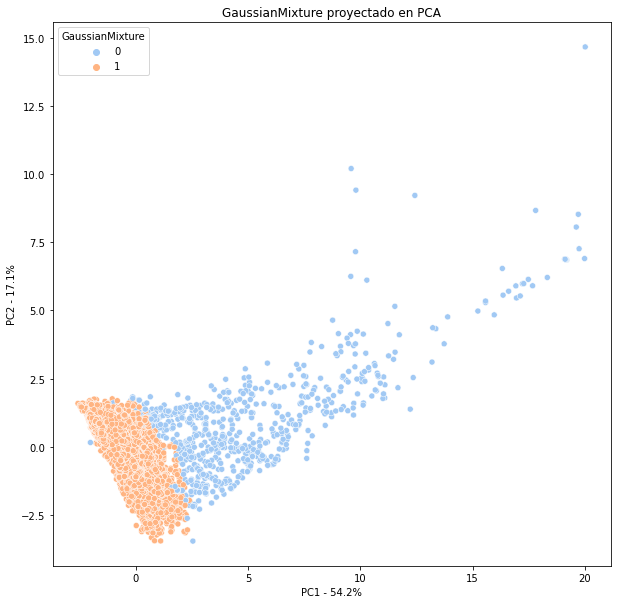

In [74]:
gm = GaussianMixture(n_components=2, random_state=0)

datos_gm = gm.fit_predict(X)
datos_gm_v = gm.fit_predict(X_valid)

gm_pd = pd.DataFrame(datos_gm, columns=['GaussianMixture'])
gm_v_pd = pd.DataFrame(datos_gm_v, columns=['GaussianMixture'])

pca_gm = pca_df_X.join(gm_pd)
pca_gm_v = pca_df_X_valid.join(gm_v_pd)


fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_gm, hue='GaussianMixture', palette="pastel")
plt.title('GaussianMixture proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

Text(0, 0.5, 'PC2')

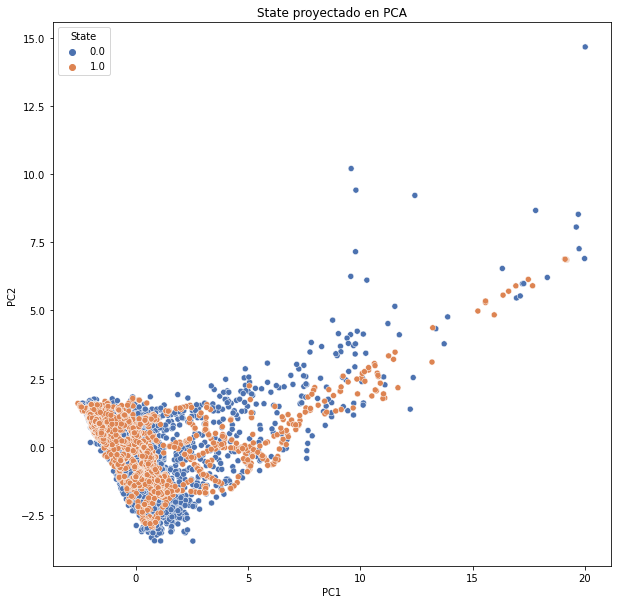

In [75]:
pca_gm__y = pca_gm.join(y)
fig = plt.figure(figsize=(10,10))  
sns.scatterplot(x='PC1', y='PC2', data=pca_gm__y, hue='State', palette="deep")
plt.title('State proyectado en PCA')
plt.xlabel('PC1')
plt.ylabel('PC2' )

#### Dataset con filtros definidos con criterio propio

Text(0, 0.5, 'PC2 - 17.6%')

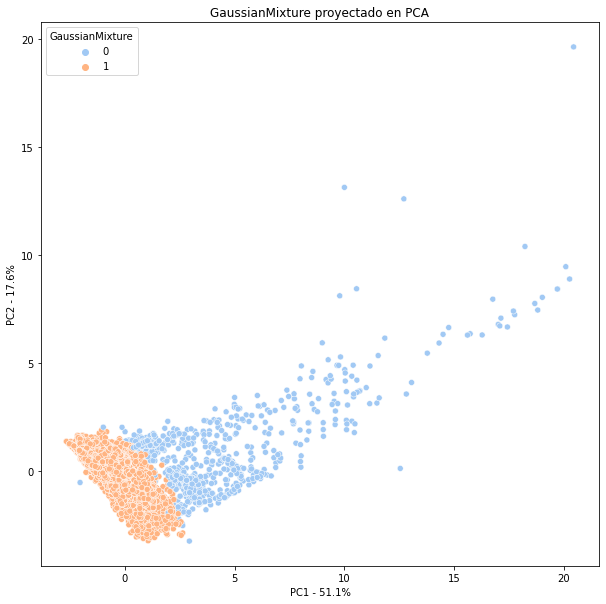

In [76]:
gm_m = GaussianMixture(n_components=2, random_state=0)
datos_gm_m = gm_m.fit_predict(X_m)
datos_gm_m_v= gm_m.predict(X_valid_m)

gm_m_pd = pd.DataFrame(datos_gm_m, columns=['GaussianMixture'])
gm_m_v_pd = pd.DataFrame(datos_gm_m_v, columns=['GaussianMixture'])

pca_gm_m = pca_df_X_m.join(gm_m_pd)
pca_gm_m_v = pca_df_X_valid_m.join(gm_m_v_pd)


fig = plt.figure(figsize=(10,10))  

sns.scatterplot(x='PC1', y='PC2', data=pca_gm_m, hue='GaussianMixture', palette="pastel")
plt.title('GaussianMixture proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var_m[0]))
plt.ylabel('PC2 - {0}%'.format(per_var_m[1]))

Text(0, 0.5, 'PC2')

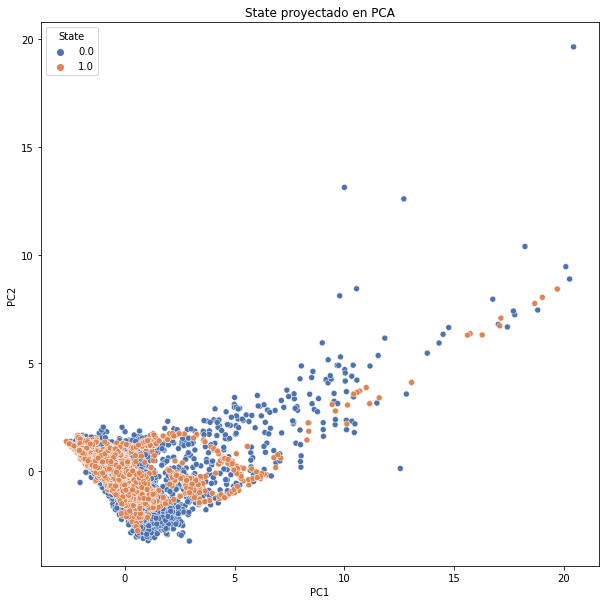

In [77]:
pca_gm_m__y = pca_gm_m.join(y_m)
fig = plt.figure(figsize=(10,10))  
sns.scatterplot(x='PC1', y='PC2', data=pca_gm_m__y, hue='State', palette="deep")
plt.title('State proyectado en PCA')
plt.xlabel('PC1')
plt.ylabel('PC2' )

#### Dataset con filtro de percentiles

Text(0, 0.5, 'PC2 - 17.6%')

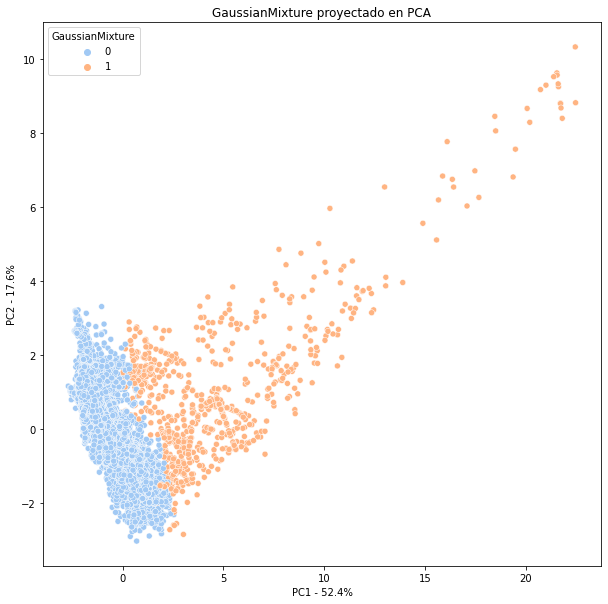

In [78]:
gm_p = GaussianMixture(n_components=2, random_state=0)
datos_gm_p = gm_p.fit_predict(X_p)
datos_gm_p_v= gm_p.predict(X_valid_p)

gm_p_pd = pd.DataFrame(datos_gm_p, columns=['GaussianMixture'])
gm_p_v_pd = pd.DataFrame(datos_gm_p_v, columns=['GaussianMixture'])

pca_gm_p = pca_df_X_p.join(gm_p_pd)
pca_gm_p_v = pca_df_X_valid_p.join(gm_p_v_pd)


fig = plt.figure(figsize=(10,10))  

sns.scatterplot(x='PC1', y='PC2', data=pca_gm_p, hue='GaussianMixture', palette="pastel")
plt.title('GaussianMixture proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var_p[0]))
plt.ylabel('PC2 - {0}%'.format(per_var_p[1]))

Text(0, 0.5, 'PC2')

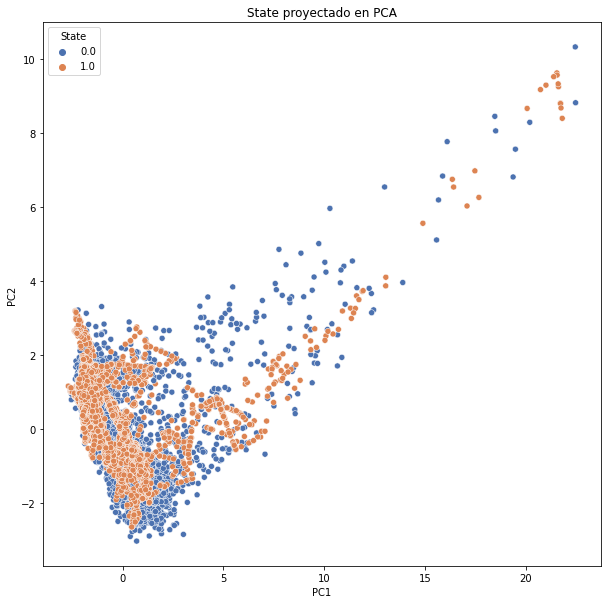

In [79]:
pca_gm_p__y = pca_gm_p.join(y_p)
fig = plt.figure(figsize=(10,10))  
sns.scatterplot(x='PC1', y='PC2', data=pca_gm_p__y, hue='State', palette="deep")
plt.title('State proyectado en PCA')
plt.xlabel('PC1')
plt.ylabel('PC2' )

#### Dataset con filtro outliers envelope

Text(0, 0.5, 'PC2 - 13.3%')

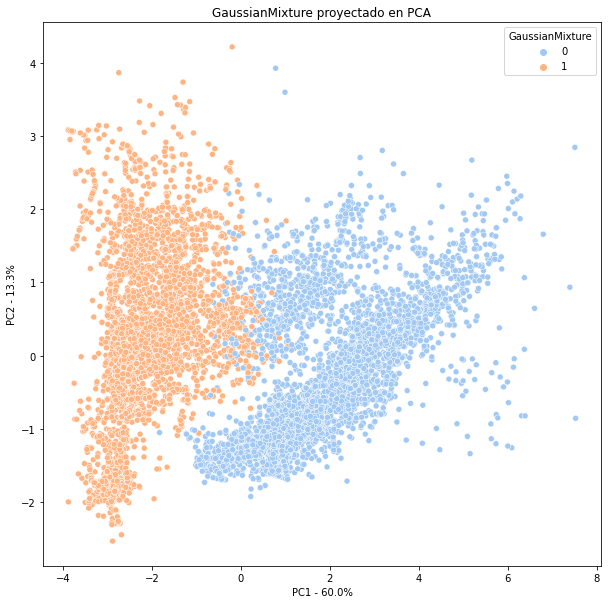

In [80]:
gm_c = GaussianMixture(n_components=2, random_state=0)
datos_gm_c = gm_c.fit_predict(X_c)
datos_gm_c_v= gm_c.fit_predict(X_valid_c)

gm_c_pd = pd.DataFrame(datos_gm_c, columns=['GaussianMixture'])
gm_c_v_pd = pd.DataFrame(datos_gm_c_v, columns=['GaussianMixture'])

pca_gm_c = pca_df_X_c.join(gm_c_pd)
pca_gm_c_v = pca_df_X_valid_c.join(gm_c_v_pd)


fig = plt.figure(figsize=(10,10))  
colors = {'1':'blue', '-1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=pca_gm_c, hue='GaussianMixture', palette="pastel")
plt.title('GaussianMixture proyectado en PCA')
plt.xlabel('PC1 - {0}%'.format(per_var_c[0]))
plt.ylabel('PC2 - {0}%'.format(per_var_c[1]))

Text(0, 0.5, 'PC2')

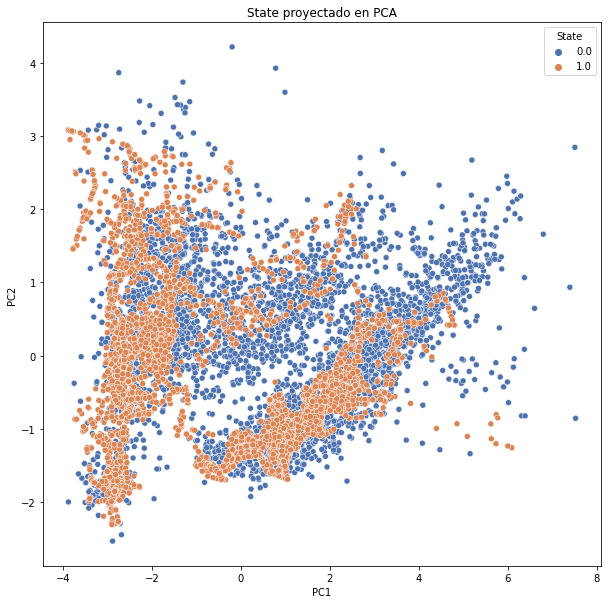

In [81]:
pca_gm_c__y = pca_gm_c.join(y_c)
fig = plt.figure(figsize=(10,10))  
sns.scatterplot(x='PC1', y='PC2', data=pca_gm_c__y, hue='State', palette="deep")
plt.title('State proyectado en PCA')
plt.xlabel('PC1')
plt.ylabel('PC2' )

### Aprendizaje Supervisado

In [82]:
X = pd.DataFrame(X, columns=x_names)
X_m = pd.DataFrame(X_m, columns=x_names_m)
X_p = pd.DataFrame(X_p, columns=x_names_p)
X_c = pd.DataFrame(X_c, columns=x_names_c)

X_valid = pd.DataFrame(X_valid, columns=x_names)
X_valid_m = pd.DataFrame(X_valid_m, columns=x_names_m)
X_valid_p = pd.DataFrame(X_valid_p, columns=x_names_p)
X_valid_c = pd.DataFrame(X_valid_c, columns=x_names_c)

In [83]:
pca_gm_x = pca_gm.join(X)
pca_gm_m_x = pca_gm_m.join(X_m)
pca_gm_p_x = pca_gm_p.join(X_p)
pca_gm_c_x = pca_gm_c.join(X_c)

pca_gm_v_x = pca_gm_v.join(X_valid)
pca_gm_m_v_x = pca_gm_m_v.join(X_valid_m)
pca_gm_p_v_x = pca_gm_p_v.join(X_valid_p)
pca_gm_c_v_x = pca_gm_c_v.join(X_valid_c)



In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

#### Dataset sin filtrar

In [85]:
clfs =  [DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
        MLPClassifier(),
        XGBClassifier(),
        GaussianNB(),
        LinearSVC()]

names = ['Arbol de decisión',
        'Random Forest', 
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM']

trained_models = []
accuracy_models = []
for clf, name in zip(clfs, names):
    print()
    print()
    print()
    print(name)
    print()
    clf.fit(pca_gm_x, y)
    train_predictions_ = clf.predict(pca_gm_x)
    accuracy = accuracy_score(y, train_predictions_)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))
    cm = confusion_matrix(y, train_predictions_)
    print(cm)
    print()

    valid_predictions_ = clf.predict(pca_gm_v_x)
    accuracy = accuracy_score(y_valid, valid_predictions_)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    trained_models.append(clf)    
    accuracy_models.append(accuracy)

    print("Métricas de validación para el mejor ajuste")
    print("Precision = %s" % precision_score(y_valid, valid_predictions_))
    print("Recall = %s" % recall_score(y_valid, valid_predictions_))
    print("F1 = %s" % f1_score(y_valid, valid_predictions_))
    print("roc_score  = %s" % roc_auc_score(y_valid, valid_predictions_))
    cm = confusion_matrix(y_valid, valid_predictions_)
    print(cm)




Arbol de decisión

Accuracy train Arbol de decisión: 100.00%
[[4416    0]
 [   0 4390]]

Accuracy test Arbol de decisión: 81.00%
Métricas de validación para el mejor ajuste
Precision = 0.12376237623762376
Recall = 0.3333333333333333
F1 = 0.18050541516245489
roc_score  = 0.5876488095238095
[[943 177]
 [ 50  25]]



Random Forest

Accuracy train Random Forest: 100.00%
[[4416    0]
 [   0 4390]]

Accuracy test Random Forest: 84.02%
Métricas de validación para el mejor ajuste
Precision = 0.1375
Recall = 0.29333333333333333
F1 = 0.1872340425531915
roc_score  = 0.5850595238095238
[[982 138]
 [ 53  22]]



Regresión Logística

Accuracy train Regresión Logística: 63.09%
[[2650 1766]
 [1484 2906]]

Accuracy test Regresión Logística: 61.51%
Métricas de validación para el mejor ajuste
Precision = 0.1079429735234216
Recall = 0.7066666666666667
F1 = 0.1872791519434629
roc_score  = 0.6577976190476191
[[682 438]
 [ 22  53]]



Perceptrón multicapa

Accuracy train Perceptrón multicapa: 75.23%
[[309

#### Dataset con filtro definidos con criterio propio

In [86]:
clfs =  [DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
        MLPClassifier(),
        XGBClassifier(),
        GaussianNB(),
        LinearSVC()]

names = ['Arbol de decisión',
        'Random Forest', 
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM']

trained_models = []
accuracy_models = []
for clf, name in zip(clfs, names):
    print()
    print()
    print()
    print(name)
    print()
    clf.fit(pca_gm_m_x, y_m)
    train_predictions_m = clf.predict(pca_gm_m_x)
    accuracy = accuracy_score(y_m, train_predictions_m)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))
    cm = confusion_matrix(y_m, train_predictions_m)
    print(cm)
    print()
    valid_predictions_m = clf.predict(pca_gm_m_v_x)
    accuracy = accuracy_score(y_valid_m, valid_predictions_m)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    trained_models.append(clf)    
    accuracy_models.append(accuracy)

    
    print("Métricas de validación para el mejor ajuste")
    print("Precision = %s" % precision_score(y_valid_m, valid_predictions_m))
    print("Recall = %s" % recall_score(y_valid_m, valid_predictions_m))
    print("F1 = %s" % f1_score(y_valid_m, valid_predictions_m))
    print("roc_score  = %s" % roc_auc_score(y_valid_m, valid_predictions_m))
    cm = confusion_matrix(y_valid_m, valid_predictions_m)
    print(cm)
    




Arbol de decisión

Accuracy train Arbol de decisión: 100.00%
[[4393    0]
 [   0 4394]]

Accuracy test Arbol de decisión: 80.64%
Métricas de validación para el mejor ajuste
Precision = 0.14218009478672985
Recall = 0.38461538461538464
F1 = 0.20761245674740486
roc_score  = 0.6104072398190045
[[924 181]
 [ 48  30]]



Random Forest

Accuracy train Random Forest: 100.00%
[[4393    0]
 [   0 4394]]

Accuracy test Random Forest: 84.02%
Métricas de validación para el mejor ajuste
Precision = 0.17159763313609466
Recall = 0.3717948717948718
F1 = 0.23481781376518218
roc_score  = 0.6225490196078431
[[965 140]
 [ 49  29]]



Regresión Logística

Accuracy train Regresión Logística: 64.08%
[[2633 1760]
 [1396 2998]]

Accuracy test Regresión Logística: 58.24%
Métricas de validación para el mejor ajuste
Precision = 0.10606060606060606
Recall = 0.717948717948718
F1 = 0.1848184818481848
roc_score  = 0.6453996983408747
[[633 472]
 [ 22  56]]



Perceptrón multicapa

Accuracy train Perceptrón multicapa

#### Dataset con filtro de Percentiles

In [87]:
clfs =  [DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
        MLPClassifier(),
        XGBClassifier(),
        GaussianNB(),
        LinearSVC()]

names = ['Arbol de decisión',
        'Random Forest', 
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM']

trained_models = []
accuracy_models = []
for clf, name in zip(clfs, names):
    print()
    print()
    print()
    print(name)
    print()
    clf.fit(pca_gm_p_x, y_p)
    train_predictions = clf.predict(pca_gm_p_x)
    accuracy = accuracy_score(y_p, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))
    cm = confusion_matrix(y_p, train_predictions)
    print(cm)
    print()


    valid_predictions_p = clf.predict(pca_gm_p_v_x)
    accuracy = accuracy_score(y_valid_p, valid_predictions_p)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    trained_models.append(clf)    
    accuracy_models.append(accuracy)

    print("Métricas de validación para el mejor ajuste")
    print("Precision = %s" % precision_score(y_valid_p, valid_predictions_p))
    print("Recall = %s" % recall_score(y_valid_p, valid_predictions_p))
    print("F1 = %s" % f1_score(y_valid_p, valid_predictions_p))
    print("roc_score  = %s" % roc_auc_score(y_valid_p, valid_predictions_p))

    cm = confusion_matrix(y_valid_p, valid_predictions_p)
    print(cm)





Arbol de decisión

Accuracy train Arbol de decisión: 100.00%
[[4349    0]
 [   0 4384]]

Accuracy test Arbol de decisión: 79.85%
Métricas de validación para el mejor ajuste
Precision = 0.14634146341463414
Recall = 0.32967032967032966
F1 = 0.20270270270270271
roc_score  = 0.5838166463166463
[[905 175]
 [ 61  30]]



Random Forest

Accuracy train Random Forest: 100.00%
[[4349    0]
 [   0 4384]]

Accuracy test Random Forest: 82.75%
Métricas de validación para el mejor ajuste
Precision = 0.15950920245398773
Recall = 0.2857142857142857
F1 = 0.20472440944881892
roc_score  = 0.5794312169312168
[[943 137]
 [ 65  26]]



Regresión Logística

Accuracy train Regresión Logística: 62.81%
[[2641 1708]
 [1540 2844]]

Accuracy test Regresión Logística: 62.25%
Métricas de validación para el mejor ajuste
Precision = 0.1336116910229645
Recall = 0.7032967032967034
F1 = 0.22456140350877193
roc_score  = 0.6595187220187221
[[665 415]
 [ 27  64]]



Perceptrón multicapa

Accuracy train Perceptrón multicap

#### Dataset con filtro outliers envelope

In [88]:
clfs =  [DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
        MLPClassifier(),
        XGBClassifier(),
        GaussianNB(),
        LinearSVC()]

names = ['Arbol de decisión',
        'Random Forest', 
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM']

trained_models = []
accuracy_models = []
for clf, name in zip(clfs, names):
    print()
    print()
    print()
    print(name)
    print()
    clf.fit(pca_gm_c_x, y_c)
    train_predictions = clf.predict(pca_gm_c_x)
    accuracy = accuracy_score(y_c, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))
    cm = confusion_matrix(y_c, train_predictions)
    print(cm)
    print()

    valid_predictions_c = clf.predict(pca_gm_c_v_x)
    accuracy = accuracy_score(y_valid_c, valid_predictions_c)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    trained_models.append(clf)    
    accuracy_models.append(accuracy)

    print("Métricas de validación para el mejor ajuste")
    print("Precision = %s" % precision_score(y_valid_c, valid_predictions_c))
    print("Recall = %s" % recall_score(y_valid_c, valid_predictions_c))
    print("F1 = %s" % f1_score(y_valid_c, valid_predictions_c))
    print("roc_score  = %s" % roc_auc_score(y_valid_c, valid_predictions_c))
    cm = confusion_matrix(y_valid_c, valid_predictions_c)
    print(cm)




Arbol de decisión

Accuracy train Arbol de decisión: 100.00%
[[3932    0]
 [   0 4042]]

Accuracy test Arbol de decisión: 79.70%
Métricas de validación para el mejor ajuste
Precision = 0.11330049261083744
Recall = 0.40350877192982454
F1 = 0.1769230769230769
roc_score  = 0.6114835735276003
[[817 180]
 [ 34  23]]



Random Forest

Accuracy train Random Forest: 100.00%
[[3932    0]
 [   0 4042]]

Accuracy test Random Forest: 83.97%
Métricas de validación para el mejor ajuste
Precision = 0.1056338028169014
Recall = 0.2631578947368421
F1 = 0.1507537688442211
roc_score  = 0.5678878741487621
[[870 127]
 [ 42  15]]



Regresión Logística

Accuracy train Regresión Logística: 65.68%
[[2256 1676]
 [1061 2981]]

Accuracy test Regresión Logística: 59.77%
Métricas de validación para el mejor ajuste
Precision = 0.08009153318077804
Recall = 0.6140350877192983
F1 = 0.1417004048582996
roc_score  = 0.6054127294163191
[[595 402]
 [ 22  35]]



Perceptrón multicapa

Accuracy train Perceptrón multicapa: 

### Conclusion 

No se obtuvieron separaciones en clusters apreciables al menos en los datos proyectados sobre PCA para las tecnicas elegidas, ni tampoco se observo una mejora apreciable en la separacion de outliers para los filtros de anomalias elegidos. Se obtuvo un resultado interesante cuando se utilizo el clustering realizado por la mezcla de gaussianas con los datos previamente filtrados utilizando Elliptic Envelope para outliers. Si bien la separación en clusters observada luego de aplicar esta técnica fue interesante, no se observo que esta correspondiera a una separación basada en los estados normal y pre-ictal que corresponden a las etiquetas. Claramente la separacion se esta debiendo a otro fenómeno o otra característica de los datos que no podemos establecer al menos ahora. Se debería investigar mas en esta dirección. 

En cuanto a los métodos de aprendizaje supervisado aplicados, no podemos concluir que se hayan obtenido resultados satisfactorios en las metricas, a pesar de agregar informacion tanto de PCA como de los clusters en los diferentes datasets. Resulta interesante observas las matrices de confusión de los conjuntos de test para los modelos entrenados. Dada la naturaleza de nuestro set de datos, es deseable que se clasifiquen como falsos negativos tan pocos casos como sea posible, ya que es preferible clasificar a un estado normal como un estado pre-ictal que clasificar a un episodio epiléptico como normal. Sin embargo, observando la segunda fila de las matrices de confusion, que corresponde a como los modelos clasifican los estados pre-ictales, observamos que la mayoria de ellos son incorrectamente clasificados para la mayoria de los modelos, salvo para algunos clasificadores como SVM y Naive-Bayes, que por otro lado obtienen accuracys muy bajas comparadas con los demas (lo que significa que clasifica una gran cantidad de estados normales como pre-ictales, lo cual tampoco es un buen desempeño del modelo). 